files in ~/Library/Mobile Documents/com~apple~CloudDocs/Conferences/2023/Ferrarra/babel

In [1]:
# Required for data handling and manipulation
import pandas as pd

# TensorFlow and tf.keras for neural networks or deep learning
import tensorflow as tf
from tensorflow import keras

# Let's verify the TensorFlow version while we are at it
print(tf.__version__)


2.13.0


In [2]:
# Replace 'file_path' with the path to your .csv.gz file
df = pd.read_csv('~/Library/Mobile Documents/com~apple~CloudDocs/Conferences/2023/Ferrarra/babel/YJNRC18-AF.csv.gz', compression='gzip')

# Let's take a look at the first few rows of the DataFrame
print(df.head())


           chr    pos alleles  GT1  GT2  ADcross  DPcross  AD3_0  AD3_1   
0  chromosome1  27781     C,T  0/0  1|1    68,86      154     68     86  \
1  chromosome1  27783     A,G  0/0  1|1    68,89      157     68     89   
2  chromosome1  27882     G,T  0/0  1/1  134,145      279    134    145   
3  chromosome1  27892     G,A  1/1  0/0  148,128      276    148    128   
4  chromosome1  27914     T,C  0/0  1/1  129,143      272    129    143   

   AD3_2  AD3_3  Allele1  Allele2  AD_A1  AD_A2  global_pos  sumCount   
0    NaN    NaN        0        1     68     86       27781       154  \
1    NaN    NaN        0        1     68     89       27783       157   
2    NaN    NaN        0        1    134    145       27882       279   
3    NaN    NaN        1        0    128    148       27892       276   
4    NaN    NaN        0        1    129    143       27914       272   

   smoothed       lwr       upr  
0  0.477671  0.468844  0.486497  
1  0.477671  0.468845  0.486497  
2  0.477

In [3]:
AF = df["AD_A1"] / df["sumCount"]
AF

0        0.441558
1        0.433121
2        0.480287
3        0.463768
4        0.474265
           ...   
38057    0.493392
38058    0.483193
38059    0.458150
38060    0.506550
38061    0.567839
Length: 38062, dtype: float64

In [148]:
np.max(AF)

0.939622641509434

In [155]:
import pandas as pd

def smooth_data(data, window_size):
    series = pd.Series(data)
    series = series.rolling(window_size).mean().to_numpy()
    if window_size>0:
        series[0:(window_size-1)]=smooth_data(data[0:(window_size-1)],window_size-1)
    return series



AF_smooth=smooth_data(AF, 1000)

In [156]:
np.max(AF_smooth)

0.7654697004393407

In [157]:
#training_mean = AF_smooth.mean()
#training_std = AF_smooth.std()
#AF_normalized = (AF_smooth - training_mean) / training_std

In [158]:
import numpy as np
# Tensorflow laden
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [187]:
window_size=300
step=1
def create_windows(data, window_size, step):
    return [data[i:i+window_size] for i in range(0, len(data)-window_size+1, step)]
nested_list = create_windows(AF_smooth, window_size, step)




nested_list=np.array(nested_list)
std_list=list()
avg_list=list()

for i in range(len(nested_list)):
    training_mean = nested_list[i].mean()
    training_std = nested_list[i].std()
    std_list.append(training_std)
    avg_list.append(training_mean)
    if training_std != 0:
        nested_list[i] = (nested_list[i] - training_mean) / training_std
    else:
        nested_list[i] = np.zeros_like(nested_list[i])



# Define some constants
latent_size = 5  # size of the encoded representations
pooling_size = 10
num_filters = 20  # number of convolutional filters
kernel_size = 50  # size of the convolutional filters
dense_units = latent_size*16  # number of units in the dense layers
dropout_rate = 0.2  # dropout rate

new_window_size=int(window_size * num_filters)  # Adjusted window size after pooling

encoder = keras.Sequential([
    
    # Reshape the input to add an extra dimension
    layers.Reshape((window_size, 1)),  
    
    #layers.AveragePooling1D(pooling_size), # reduce noise

    # Conv1D layer with `num_filters` filters, each of size `kernel_size`
    layers.Conv1D(num_filters, kernel_size = kernel_size, activation = "relu"),  

    # Flatten layer to reshape the 3D output to 2D
    layers.Flatten(),

    # Dense layer with `dense_units` units
    layers.Dense(dense_units, activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/2), activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/4), activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/8), activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),

    # Dense layer with `latent_size` units
    layers.Dense(latent_size)
])

decoder = keras.Sequential([
    # Input layer expecting a 1D input of size `latent_size`
    keras.Input(shape=(latent_size,)),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/8), activation = "relu"),

    # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),
    
    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/4), activation = "relu"),
    
     # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),

    # Dense layer with `dense_units` units
    layers.Dense(int(dense_units/2), activation="relu"),
    
     # Dropout layer with dropout rate of `dropout_rate`
    layers.Dropout(dropout_rate),

    # Dense layer with `dense_units` units
    layers.Dense(dense_units, activation="relu"),

    # Dense layer with `window_size * num_filters` units
    layers.Dense(window_size * num_filters, activation="relu"),

    # Reshape layer to get ready for a Conv1DTranspose layer
    layers.Reshape((new_window_size,)),  # Adjusted window size after pooling

    # Flatten layer to prepare for the final Dense layer
    layers.Flatten(),
    
    # Final Dense layer with `window_size` units
    layers.Dense(window_size, activation="linear")
])



start = keras.Input(shape = (window_size,))
latent_vector = encoder(start)
output = decoder(latent_vector)

model = keras.Model(inputs = start, outputs = output)
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
    loss = keras.losses.MeanSquaredError(),
    metrics = [
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanAbsolutePercentageError()
    ]
)

EPOCHS = 10

model.fit(nested_list, nested_list, epochs = EPOCHS, batch_size=10)

Epoch 1/10
3777/3777 [==============================] - 31s 8ms/step - loss: 0.2198 - mean_absolute_error: 0.2973 - mean_absolute_percentage_error: 232.8366
Epoch 2/10
3777/3777 [==============================] - 30s 8ms/step - loss: 0.2439 - mean_absolute_error: 0.3043 - mean_absolute_percentage_error: 230.0629
Epoch 3/10
3777/3777 [==============================] - 30s 8ms/step - loss: 0.2378 - mean_absolute_error: 0.3010 - mean_absolute_percentage_error: 239.2694
Epoch 4/10
3777/3777 [==============================] - 30s 8ms/step - loss: 0.2011 - mean_absolute_error: 0.2717 - mean_absolute_percentage_error: 229.0353
Epoch 5/10
3777/3777 [==============================] - 30s 8ms/step - loss: 0.2375 - mean_absolute_error: 0.3017 - mean_absolute_percentage_error: 228.6290
Epoch 6/10
3777/3777 [==============================] - 31s 8ms/step - loss: 0.1737 - mean_absolute_error: 0.2566 - mean_absolute_percentage_error: 222.1487
Epoch 7/10
3777/3777 [==============================] - 32

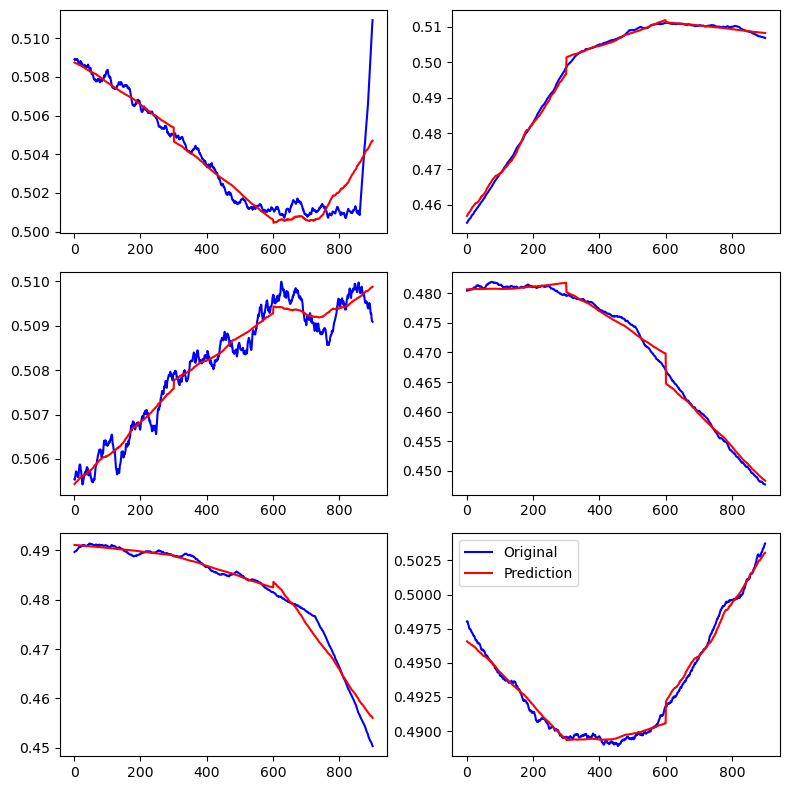

In [188]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # 5x4 subplots

# Reshape axs for easier iteration
axs = axs.reshape(-1)

x = 3  # number of consecutive nested_list items to take in each iteration
step = 300  # step size between each item

for i, ax in enumerate(axs):
    # Choose the starting index such that enough consecutive items can be taken
    start_idx = np.random.randint(0, len(nested_list) - (x-1)*step)
    idxs = [start_idx + j*step for j in range(x)]  # indices of the items to be taken

    # Concatenate samples and predictions from each index
    samples = []
    predictions = []
    for idx in idxs:
        sample = nested_list[idx]
        sample = sample[np.newaxis, :]  # Add an extra dimension for batch_size
        prediction = model.predict(sample, verbose=0)

        # Remove extra dimensions for visualization
        sample = sample[0]*std_list[idx]
        prediction = prediction[0]*std_list[idx]
        
        sample=sample+avg_list[idx]
        prediction=prediction+avg_list[idx]

        samples.append(sample)
        predictions.append(prediction)

    # Concatenate along the time axis (axis=0)
    samples = np.concatenate(samples, axis=0)
    predictions = np.concatenate(predictions, axis=0)

    # Plot the original data in blue
    ax.plot(range(1, len(samples) + 1), samples, color='blue', label='Original')

    # Plot the model's prediction in red
    ax.plot(range(1, len(predictions) + 1), predictions, color='red', label='Prediction')

    # If you want legends on all subplots uncomment below line
    # ax.legend()

# Show legends for the last subplot
axs[-1].legend()

plt.tight_layout()
plt.show()


What I can do now is I can cluster the latent variables for each position and then use those clusters to detect clusters / autoencode consecutive clusters and then see if those correspond to TRD loci